##### Dicionário de dados

<ul> 
<li><strong>checking_status:</strong> Status da conta corrente existente</li>
<li><strong>duration:</strong> Duração em meses</li>
<li><strong>credit_history:</strong> Histórico de crédito</li>
<li><strong>purpose:</strong> Finalidade do crédito</li>
<li><strong>credit_amount:</strong> Valor do crédito</li>
<li><strong>savings_status:</strong> Situação da conta poupança/título</li>
<li><strong>employment:</strong> Emprego atual, em número de anos</li>
<li><strong>installment_commitment:</strong> Taxa de prestação em percentagem do rendimento</li>
<li><strong>personal_status:</strong> sexo e dados conjugais</li>
<li><strong>other_parties:</strong> Outros devedores / fiadores</li>
<li><strong>residence_since:</strong> residência desde?</li>
<li><strong>property_magnitude:</strong> magnitude da propriedade</li>
<li><strong>age:</strong> idade</li>
<li><strong>other_payment_plans:</strong> outros planos de pagamento</li>
<li><strong>housing:</strong> Habitação</li>
<li><strong>existing_credits: créditos existentes?</li>
<li><strong>job:</strong> trabalho?</li>
<li><strong>num_dependents:</strong> Número de dependentes?</li>
<li><strong>own_telephone:</strong> Próprio telefone?</li>
<li><strong>foreign worker:</strong> Trabalhador estrangeiro?</li>
<li><strong>class:</strong> classe/alvo?</li>
</ul>

<a href="https://money.stackexchange.com/questions/35860/what-is-an-installment-rate-percentage">Sobre: installment_commitment</a>

<a href="https://www.openml.org/search?type=data&sort=runs&status=active&id=31">Outros</a>  

<a href="https://www.kaggle.com/datasets/ppb00x/credit-risk-customers">Fonte do dataset</a>  

Tamanho da Amostra: 1000

#### Objetivo

<p>Prever se os clientes são arriscados ou não para crédito</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('credit_customers.csv')

##### Funções utilidades

In [4]:
# essa função cria 4 categorias de tempo de trabalho:
# desempregado (Péssimo)
# menor que 1 ano (Ruim)
# maior que 1 e menor que 4 (Quase bom) 
# Maior que 4 e menor que 7 (Bom)
# Maior ou igual a 7 (Otimo)

def trata_employment(x):
    
    if len(x) == 2:
        if x[-2] == '<':
            return 'bad' #só existe um caso que é igual a 2 (<1)
        
    if len(x) == 3:
        return 'great' # só existe um caso que é igual a 3 (>=7)
    
    if len(x) == 6:
        if x[-1] == '7':
            return 'good'
        
        if x[-1] == '4':
            return 'almost good'
        
    if len(x) == 10:
        return 'very bad'
    
    else:
        return ''
    
def trata_savings_status(x):
    
    if len(x) == 16:
        return 'without balance' #só existe um caso para o tamanho de cada qtd de caracters
        
    if len(x) == 4:
        return 'less then 100' # só existe um caso que é igual a 3 (<100)
    
    if len(x) == 10:
        return 'between 100 and 500'
        
    if len(x) == 11:
        return 'between 500 and 1000'
    
    if len(x) == 6:
        return 'between or equal 1000'
    
    else:
        return ''

def trata_checking_status(x):
    
    if len(x) == 2:
        return 'without balance' #só existe um caso para o tamanho de cada qtd de caracters
        
    if len(x) == 11:
        return x # só existe um caso que é igual a 3 (no checking)
    
    if len(x) == 8:
        return 'between 0 and 200'
        
    if len(x) == 5:
        return 'great or equal 200'
    
    else:
        return ''
    
def substitui_caracter(x):
    
    if '/' in x:
        return x.replace('/',' or ')
    else:
        return x
    
def trata_personal_status(x):
    if len(x.split(' ')[1]) > 6:
        return 'married'    # pessoas que já foram casadas ou são, inclui viovo(a) e divorciado(a)
    else:
        return x.split(' ')[1]
    
def trata_classificacao(x):
    if x.strip() == 'good':
        return 1    # pessoas que já foram casadas ou são, inclui viovo(a) e divorciado(a)
    else:
        return 0
    

### 01 - Pré processamento

In [5]:
data.head(50)
##data.tail()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
5,no checking,36.0,existing paid,education,9055.0,no known savings,1<=X<4,2.0,male single,none,...,no known property,35.0,none,for free,1.0,unskilled resident,2.0,yes,yes,good
6,no checking,24.0,existing paid,furniture/equipment,2835.0,500<=X<1000,>=7,3.0,male single,none,...,life insurance,53.0,none,own,1.0,skilled,1.0,none,yes,good
7,0<=X<200,36.0,existing paid,used car,6948.0,<100,1<=X<4,2.0,male single,none,...,car,35.0,none,rent,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
8,no checking,12.0,existing paid,radio/tv,3059.0,>=1000,4<=X<7,2.0,male div/sep,none,...,real estate,61.0,none,own,1.0,unskilled resident,1.0,none,yes,good
9,0<=X<200,30.0,critical/other existing credit,new car,5234.0,<100,unemployed,4.0,male mar/wid,none,...,car,28.0,none,own,2.0,high qualif/self emp/mgmt,1.0,none,yes,bad


In [6]:
# Verificando se exesti valores nulos
data.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

##### Faz limpeza em algumas colunas

In [7]:
data_clean = data  # preservar o dataframe original

data_clean['employment'] = data_clean['employment'].map(trata_employment)

data_clean['checking_status'] = data_clean['checking_status'].map(trata_checking_status)

data_clean['savings_status'] = data_clean['savings_status'].map(trata_savings_status)

# cria nova coluna sexo, extraida de personal_status
data_clean['gender'] = data_clean['personal_status'].map(lambda x: x.split(' ')[0])

data_clean['credit_history'] = data_clean['credit_history'].map(substitui_caracter) # substitui '/' por 'or'

data_clean['purpose'] = data_clean['purpose'].map(substitui_caracter) # substitui '/' por 'or'

# extrai apenas situação conjugal
data_clean['personal_status'] = data_clean['personal_status'].map(trata_personal_status)

data_clean.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,gender
0,without balance,6.0,critical or other existing credit,radio or tv,1169.0,without balance,great,4.0,single,none,...,67.0,none,own,2.0,skilled,1.0,yes,yes,good,male
1,between 0 and 200,48.0,existing paid,radio or tv,5951.0,less then 100,almost good,2.0,married,none,...,22.0,none,own,1.0,skilled,1.0,none,yes,bad,female
2,no checking,12.0,critical or other existing credit,education,2096.0,less then 100,good,2.0,single,none,...,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good,male
3,without balance,42.0,existing paid,furniture or equipment,7882.0,less then 100,good,2.0,single,guarantor,...,45.0,none,for free,1.0,skilled,2.0,none,yes,good,male
4,without balance,24.0,delayed previously,new car,4870.0,less then 100,almost good,3.0,single,none,...,53.0,none,for free,2.0,skilled,2.0,none,yes,bad,male


In [8]:
# Verificando se exesti valores nulos
data_clean.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
gender                    0
dtype: int64

In [9]:
# Renomeia as colunas para tornar mais fácil a compreensão da análise

colunas = {'checking_status': 'conta_corrente', 'duration': 'qtd_meses', 'credit_history': 'historico_credito', 
           'purpose': 'proposito_credito', 'credit_amount': 'credito_solicitado', 'savings_status': 'saldo_poupanca',
           'employment': 'emprego_atual', 'installment_commitment': 'taxa_prestacoes_atual', 'personal_status': 'estado_civil',
           'other_parties': 'fiadores', 'residence_since': 'reside_anos', 'property_magnitude': 'bens', 'age': 'idade',
           'other_payment_plans': 'outros_parcelamentos', 'housing':'tipo_habitacao', 'existing_credits': 'credito_existente',
           'job': 'trabalho', 'num_dependents': 'qtd_dependentes', 'own_telephone': 'telefone', 'foreign_worker': 'trabalhador_estrangeiro',
           'class': 'classificacao', 'gender': 'sexo'}

data_clean.rename(columns=colunas, inplace = True)

### 02 - Análise diagnóstica

In [11]:
data_clean.describe(include=['int64', 'float64']).round(2)

,qtd_meses,credito_solicitado,taxa_prestacoes_atual,reside_anos,idade,credito_existente,qtd_dependentes
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,20.90,3271.26,2.97,2.84,35.55,1.41,1.16
std,12.06,2822.74,1.12,1.10,11.38,0.58,0.36
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00
25%,12.00,1365.50,2.00,2.00,27.00,1.00,1.00
50%,18.00,2319.50,3.00,3.00,33.00,1.00,1.00
75%,24.00,3972.25,4.00,4.00,42.00,2.00,1.00
max,72.00,18424.00,4.00,4.00,75.00,4.00,2.00


<p>Observações sobre o describe</p>
<ul> 
<li>A média da idade das pessoas é de 35 anos. A pessoa com maior idade têm 75 anos e a com menor idade têm 19 anos.</li>
<li>Outra observação é que todos que requisitaram crédito tem pelo menos um dependente. Isso pode ser observado no valor mínimo da qtd_dependentes.</li>
<li>O limite médio de crédito solicitado foi de 2822 euros, sendo o menor valor 250 euros e o maior valor 18424 euros.</li>
</ul> 

In [12]:
# salvando os dados após a limpeza.
data_clean.to_csv('dados_limpos.csv', sep=',', index=False)

In [4]:
data_analise = pd.read_csv('dados_limpos.csv')

<p>-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</p> 

<p> Vamos observar as propoção de classificações boas e ruins,  pelo sexo, pelo tipo de trabalhador e por fiadores. O objetivo é verificar essas proporções com todos os dados, e verificar em seguida, se as proporções  (pelo sexo, pelo tipo de trabalhador e por fiadores) se matem equivalentes para os dados com apenas boas classificações. Se a propoção se mantiver equivalente entre o dataset completo e o dataset com a penas boa classificação no alvo, isso indica que as variáveis não têm, ou têm pouca influência sobre o alvo.</p>   

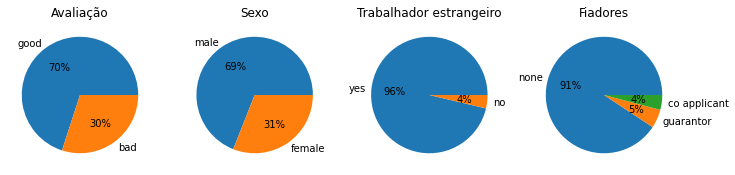

In [5]:
##data_analise = data_clean.copy()
# dataset completo

fig,ax = plt.subplots(1, 4,figsize = ((12, 6)))
ax[0].pie(data_analise['classificacao'].value_counts().values, labels=data_analise['classificacao'].value_counts().keys(), autopct='%.0f%%')
ax[0].set_title('Avaliação')


ax[1].pie(data_analise['sexo'].value_counts().values, labels=data_analise['sexo'].value_counts().keys(), autopct='%.0f%%')
ax[1].set_title('Sexo')


ax[2].pie(data_analise['trabalhador_estrangeiro'].value_counts().values, labels=data_analise['trabalhador_estrangeiro'].value_counts().keys(), autopct='%.0f%%')
ax[2].set_title('Trabalhador estrangeiro')


ax[3].pie(data_analise['fiadores'].value_counts().values, labels=data_analise['fiadores'].value_counts().keys(), autopct='%.0f%%')
ax[3].set_title('Fiadores')

plt.show()

In [6]:
# Filtrado apenas boas avaliações pelo banco
data_analise_good = data_analise.loc[data_analise.classificacao == 'good']
data_analise_good

,conta_corrente,qtd_meses,historico_credito,proposito_credito,credito_solicitado,saldo_poupanca,emprego_atual,taxa_prestacoes_atual,estado_civil,fiadores,...,idade,outros_parcelamentos,tipo_habitacao,credito_existente,trabalho,qtd_dependentes,telefone,trabalhador_estrangeiro,classificacao,sexo
0,without balance,6.0,critical or other existing credit,radio or tv,1169.0,without balance,great,4.0,single,none,...,67.0,none,own,2.0,skilled,1.0,yes,yes,good,male
2,no checking,12.0,critical or other existing credit,education,2096.0,less then 100,good,2.0,single,none,...,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good,male
3,without balance,42.0,existing paid,furniture or equipment,7882.0,less then 100,good,2.0,single,guarantor,...,45.0,none,for free,1.0,skilled,2.0,none,yes,good,male
5,no checking,36.0,existing paid,education,9055.0,without balance,almost good,2.0,single,none,...,35.0,none,for free,1.0,unskilled resident,2.0,yes,yes,good,male
6,no checking,24.0,existing paid,furniture or equipment,2835.0,between 500 and 1000,great,3.0,single,none,...,53.0,none,own,1.0,skilled,1.0,none,yes,good,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,no checking,12.0,existing paid,new car,2390.0,without balance,great,4.0,single,none,...,50.0,none,own,1.0,skilled,1.0,yes,yes,good,male
995,no checking,12.0,existing paid,furniture or equipment,1736.0,less then 100,good,3.0,married,none,...,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good,female
996,without balance,30.0,existing paid,used car,3857.0,less then 100,almost good,4.0,married,none,...,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good,male
997,no checking,12.0,existing paid,radio or tv,804.0,less then 100,great,4.0,single,none,...,38.0,none,own,1.0,skilled,1.0,none,yes,good,male


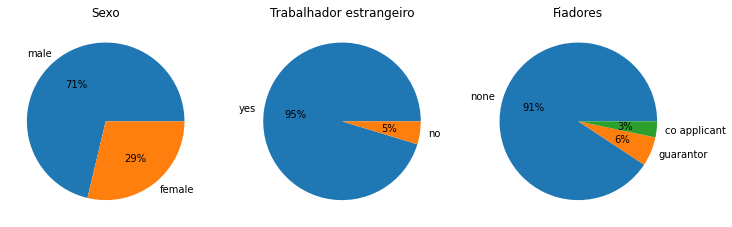

In [7]:
# datase com apenas classificação boa no alvo.

fig,ax = plt.subplots(1, 3, figsize = ((12, 6)))
ax[0].pie(data_analise_good['sexo'].value_counts().values, labels=data_analise_good['sexo'].value_counts().keys(), autopct='%.0f%%')
ax[0].set_title('Sexo')


ax[1].pie(data_analise_good['trabalhador_estrangeiro'].value_counts().values, labels=data_analise_good['trabalhador_estrangeiro'].value_counts().keys(), autopct='%.0f%%')
ax[1].set_title('Trabalhador estrangeiro')


ax[2].pie(data_analise_good['fiadores'].value_counts().values, labels=data_analise_good['fiadores'].value_counts().keys(), autopct='%.0f%%')
ax[2].set_title('Fiadores')

plt.show()

<ul> 
<li>Em relação ao sexo, vemos que está proporcional, umas vez que temos quase 70% das requisições pessoas do sexo masculino.</li>
<li>Sobre o tipo de trabalhador, a proporção foi equivalente aos dados em geral. Ou seja, o banco não desfavorece estrangeiros.</li>   
<li>Em relação a variavel fiadores, a propoção foi mantida filmente. Isso indica que o banco não leva muito em consideração se a pessoa tem fiadores ou não.</li>   
</ul> 

#### <p>Vamos verificar para quais dos propositos de crédito a classificação bom mais prevalece. </p>

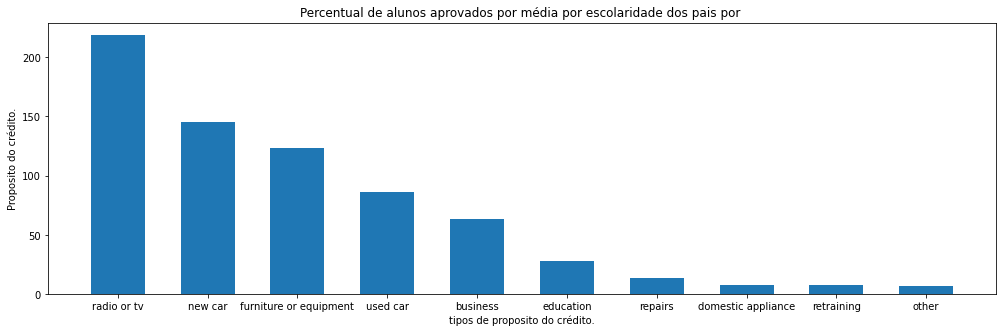

In [8]:
fig = plt.figure(figsize = (17, 5))
plt.bar(data_analise_good['proposito_credito'].value_counts().keys(), data_analise_good['proposito_credito'].value_counts().values, width = 0.6)
plt.xlabel("tipos de proposito do crédito.")
plt.ylabel("Proposito do crédito.")
plt.title("Percentual de alunos aprovados por média por escolaridade dos pais por ")
plt.show()

<p>Vamos verificar se o propósito de crédito se manterá nessa hierarquia para todo dataset.</p>

In [9]:
data_analise['proposito_credito'].value_counts()

radio or tv               280
new car                   234
furniture or equipment    181
used car                  103
business                   97
education                  50
repairs                    22
other                      12
domestic appliance         12
retraining                  9
Name: proposito_credito, dtype: int64

<p>Os propósitos de crédito mais bem avaliados também foram os mais requisitados, até aqui estão equivalentes. Vamos verificar agora os propósitos de crédito que tiveram proporcionalmente maiores classificações ruins. Vamos partir do propósito de crédito com maior classificação ruim para o com menos classificação ruim.</p>

In [10]:
percentual = (data_analise['proposito_credito'].value_counts() - data_analise_good['proposito_credito'].value_counts()) / data_analise['proposito_credito'].value_counts() * 100

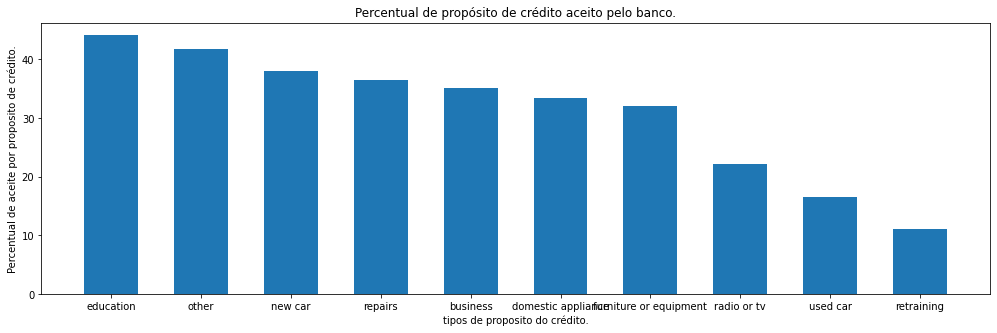

In [11]:
percentual_ordenado = percentual.sort_values(ascending=False)

fig = plt.figure(figsize = (17, 5))
plt.bar(percentual_ordenado.keys(), percentual_ordenado.values, width = 0.6)
plt.xlabel("tipos de proposito do crédito.")
plt.ylabel("Percentual de aceite por proposito de crédito.")
plt.title("Percentual de propósito de crédito aceito pelo banco.")
plt.show()

<p>Aqui temos algo muito interessante, vou chamar atenção a penas para o primeiro e último caso. 
Enquanto que o propósito de crédito educação tem mais de 40% de recusa, classificação ruim, o propósito reciclagem de profissional que também é uma categoria de educação, tem a menor recusa de crédito. Meu palpite é que a educação com maior recusa de crétido se dê pelo fato da pessoa ainda não está ou não ter atuado no mercado de trabalho, e portanto, não ter como honrar o compromisso. Já o propósito de reciclagem de profissional, têm pessoas que estão atuando no mercado de trabalho e estão pedindo crédito para se capacitarem mais e permanecerem atrativas ao mercado.</p>

<p>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</p>

<p>Vamos verificar agora quais das variáveis quantitativas têm maior co-rrelação com o alvo, classificação boa pelo banco.</p>

<p>Vamos verificar por meio de uma análise visual, se as variáveis quantitativas estão bem distribuídas. Vamos verificar o tipo das variáveis.</p>

In [12]:
data_analise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conta_corrente           1000 non-null   object 
 1   qtd_meses                1000 non-null   float64
 2   historico_credito        1000 non-null   object 
 3   proposito_credito        1000 non-null   object 
 4   credito_solicitado       1000 non-null   float64
 5   saldo_poupanca           1000 non-null   object 
 6   emprego_atual            1000 non-null   object 
 7   taxa_prestacoes_atual    1000 non-null   float64
 8   estado_civil             1000 non-null   object 
 9   fiadores                 1000 non-null   object 
 10  reside_anos              1000 non-null   float64
 11  bens                     1000 non-null   object 
 12  idade                    1000 non-null   float64
 13  outros_parcelamentos     1000 non-null   object 
 14  tipo_habitacao           

<AxesSubplot:xlabel='idade', ylabel='Density'>

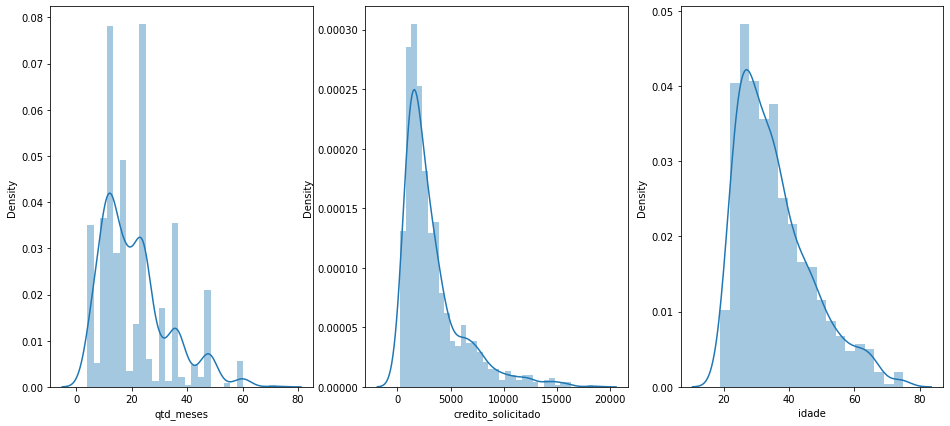

In [13]:
# Plotando gráficos histograma para termos uma visão de como estão distribuídos os dados, referente as variáveis 
# quantitativas primeiro. 

janela,graficos = plt.subplots(ncols=3, figsize=(16,7))    
sns.distplot(data_analise['qtd_meses'],ax=graficos[0]) 
sns.distplot(data_analise['credito_solicitado'],ax=graficos[1])
sns.distplot(data_analise['idade'],ax=graficos[2])

<p>Das três observações acima as que mais se aproximam de uma disribuíção normal são: credito_solicitado e qtd_meses, nessa ordem. Segue algumas observações sobre os gráficos.</p>

<ul>
<li>Os prazos para pagamento mais frequentes variam entre maior ou igual 5 e menor que 40 meses.</li>
<li>A maoria dos valores de crédito solicitado são maior que 0 e menor que 5000 mil euros.</li>
<li>A faixa etária maior que 20 e menor ou igual a 40 concentra o grupo predominante que pediram crédito ao banco.</li>
</ul>

### 03 - Análise preditiva

<p>Para da início a análise preditiva, vamos fazer uma seleção univariada das variáveis utilizando <strong>ANOVA</strong>, para isso, vamos utilizar o objeto selectBest. Por meio do selectBest, vamos selecionar as 15 melhores variáveis. Poderia, no entanto, já descartar a variável telefone empiricamente. Para utilizarmos o selectBest precisamos transformar nossas variáveis de texto em variáveis númericas. Vamos fazer isso utilizando o objeto <strong>LabelEncoder</strong>.</p> 

In [88]:
# Criando uma copia do datase data_analise e colocando a variável alvo na última coluna.

dt_analise_alvo = data_analise.copy()

x_geral = dt_analise_alvo.iloc[:,:-2]
x_geral['sexo'] = dt_analise_alvo.iloc[:,-1:]
x_geral['alvo'] = dt_analise_alvo.iloc[:,-2:-1]
x_geral.head()

,conta_corrente,qtd_meses,historico_credito,proposito_credito,credito_solicitado,saldo_poupanca,emprego_atual,taxa_prestacoes_atual,estado_civil,fiadores,...,idade,outros_parcelamentos,tipo_habitacao,credito_existente,trabalho,qtd_dependentes,telefone,trabalhador_estrangeiro,sexo,alvo
0,without balance,6.0,critical or other existing credit,radio or tv,1169.0,without balance,great,4.0,single,none,...,67.0,none,own,2.0,skilled,1.0,yes,yes,male,good
1,between 0 and 200,48.0,existing paid,radio or tv,5951.0,less then 100,almost good,2.0,married,none,...,22.0,none,own,1.0,skilled,1.0,none,yes,female,bad
2,no checking,12.0,critical or other existing credit,education,2096.0,less then 100,good,2.0,single,none,...,49.0,none,own,1.0,unskilled resident,2.0,none,yes,male,good
3,without balance,42.0,existing paid,furniture or equipment,7882.0,less then 100,good,2.0,single,guarantor,...,45.0,none,for free,1.0,skilled,2.0,none,yes,male,good
4,without balance,24.0,delayed previously,new car,4870.0,less then 100,almost good,3.0,single,none,...,53.0,none,for free,2.0,skilled,2.0,none,yes,male,bad


In [89]:
# Transformando as variáveis textuais para númericas.

label_encoder = LabelEncoder()
x_geral['conta_corrente'] = label_encoder.fit_transform(x_geral['conta_corrente'])
x_geral['historico_credito'] = label_encoder.fit_transform(x_geral['historico_credito'])
x_geral['proposito_credito'] = label_encoder.fit_transform(x_geral['proposito_credito'])
x_geral['saldo_poupanca'] = label_encoder.fit_transform(x_geral['saldo_poupanca'])
x_geral['emprego_atual'] = label_encoder.fit_transform(x_geral['emprego_atual'])
x_geral['estado_civil'] = label_encoder.fit_transform(x_geral['estado_civil'])
x_geral['fiadores'] = label_encoder.fit_transform(x_geral['fiadores'])
x_geral['bens'] = label_encoder.fit_transform(x_geral['bens'])
x_geral['outros_parcelamentos'] = label_encoder.fit_transform(x_geral['outros_parcelamentos'])
x_geral['tipo_habitacao'] = label_encoder.fit_transform(x_geral['tipo_habitacao'])
x_geral['trabalho'] = label_encoder.fit_transform(x_geral['trabalho'])
x_geral['trabalhador_estrangeiro'] = label_encoder.fit_transform(x_geral['trabalhador_estrangeiro'])
x_geral['sexo'] = label_encoder.fit_transform(x_geral['sexo'])
x_geral['alvo'] = label_encoder.fit_transform(x_geral['alvo'])
x_geral.head()

,conta_corrente,qtd_meses,historico_credito,proposito_credito,credito_solicitado,saldo_poupanca,emprego_atual,taxa_prestacoes_atual,estado_civil,fiadores,...,idade,outros_parcelamentos,tipo_habitacao,credito_existente,trabalho,qtd_dependentes,telefone,trabalhador_estrangeiro,sexo,alvo
0,3,6.0,1,6,1169.0,4,3,4.0,1,2,...,67.0,1,1,2.0,1,1.0,yes,1,1,1
1,0,48.0,3,6,5951.0,3,0,2.0,0,2,...,22.0,1,1,1.0,1,1.0,none,1,0,0
2,2,12.0,1,2,2096.0,3,2,2.0,1,2,...,49.0,1,1,1.0,3,2.0,none,1,1,1
3,3,42.0,3,3,7882.0,3,2,2.0,1,1,...,45.0,1,0,1.0,1,2.0,none,1,1,1
4,3,24.0,2,4,4870.0,3,0,3.0,1,2,...,53.0,1,0,2.0,1,2.0,none,1,1,0


In [90]:
## Aqui já descarto telefone antes da análise.
colunas = ['conta_corrente', 'qtd_meses', 'historico_credito', 'proposito_credito', 'credito_solicitado',
         'saldo_poupanca', 'emprego_atual', 'taxa_prestacoes_atual', 'estado_civil', 'fiadores', 'reside_anos',
         'bens', 'idade', 'outros_parcelamentos', 'tipo_habitacao', 'credito_existente', 'trabalho', 'qtd_dependentes',
         'trabalhador_estrangeiro', 'sexo', 'alvo']

x_geral_limpo = x_geral[colunas]
x_geral_limpo.head()

,conta_corrente,qtd_meses,historico_credito,proposito_credito,credito_solicitado,saldo_poupanca,emprego_atual,taxa_prestacoes_atual,estado_civil,fiadores,...,bens,idade,outros_parcelamentos,tipo_habitacao,credito_existente,trabalho,qtd_dependentes,trabalhador_estrangeiro,sexo,alvo
0,3,6.0,1,6,1169.0,4,3,4.0,1,2,...,3,67.0,1,1,2.0,1,1.0,1,1,1
1,0,48.0,3,6,5951.0,3,0,2.0,0,2,...,3,22.0,1,1,1.0,1,1.0,1,0,0
2,2,12.0,1,2,2096.0,3,2,2.0,1,2,...,3,49.0,1,1,1.0,3,2.0,1,1,1
3,3,42.0,3,3,7882.0,3,2,2.0,1,1,...,1,45.0,1,0,1.0,1,2.0,1,1,1
4,3,24.0,2,4,4870.0,3,0,3.0,1,2,...,2,53.0,1,0,2.0,1,2.0,1,1,0


In [91]:
# Separando a variável alvo.
alvo = x_geral_limpo['alvo']
x_geral_limpo = x_geral_limpo.iloc[:,:-1]

# SelectKBest

# Seleção de 15 atributos com SelectKBest
melhores_var = SelectKBest(score_func=f_classif, k=15)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = melhores_var.fit(x_geral_limpo, alvo)

# pega os index das variáveis selecionadas.
index = melhores_var.get_support(indices=True)

# Reduz X para os atributos selecionados
x_geral_limpo_reduzido = x_geral_limpo.iloc[:,index]

# Resultados
print('\nNúmero original de atributos:\n', x_geral_limpo.shape[1])
print('\nNúmero reduzido de atributos:\n', x_geral_limpo_reduzido.shape[1])
print('----------------------------------------------------------------------------------------')

# Exibe os atributos orginais
print("\nAtributos Originais:\n", x_geral_limpo.columns[:].values)
print('----------------------------------------------------------------------------------------')

# Exibe as pontuações de cada atributos e os 15 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:\n", fit.scores_)

print('----------------------------------------------------------------------------------------')
print("\nAtributos Selecionados:\n", x_geral_limpo_reduzido.columns[:].values)


Número original de atributos:
 20

Número reduzido de atributos:
 15
----------------------------------------------------------------------------------------

Atributos Originais:
 ['conta_corrente' 'qtd_meses' 'historico_credito' 'proposito_credito'
 'credito_solicitado' 'saldo_poupanca' 'emprego_atual'
 'taxa_prestacoes_atual' 'estado_civil' 'fiadores' 'reside_anos' 'bens'
 'idade' 'outros_parcelamentos' 'tipo_habitacao' 'credito_existente'
 'trabalho' 'qtd_dependentes' 'trabalhador_estrangeiro' 'sexo']
----------------------------------------------------------------------------------------

Scores dos Atributos Originais:
 [3.014e-01 4.833e+01 9.490e+00 1.942e+01 2.448e+01 2.305e-01 1.797e+00
 5.259e+00 6.538e+00 8.079e-01 8.787e-03 3.087e+00 8.357e+00 2.904e+00
 3.725e-01 2.092e+00 1.072e+00 9.071e-03 6.769e+00 5.720e+00]
----------------------------------------------------------------------------------------

Atributos Selecionados:
 ['qtd_meses' 'historico_credito' 'proposito_cr

##### Definição de parâmetros e partições da validação cruzada.

LR-orig: 0.704 (0.035)
--------------------------------------------------------------
KNN-orig: 0.674 (0.035)
--------------------------------------------------------------
CART-orig: 0.658 (0.054)
--------------------------------------------------------------
NB-orig: 0.686 (0.044)
--------------------------------------------------------------
SVM-orig: 0.712 (0.016)
--------------------------------------------------------------
Bag-orig: 0.741 (0.026)
--------------------------------------------------------------
RF-orig: 0.724 (0.032)
--------------------------------------------------------------
GB-orig: 0.707 (0.039)
--------------------------------------------------------------
#############################################################
LR-padr: 0.707 (0.034)
--------------------------------------------------------------
KNN-padr: 0.696 (0.030)
--------------------------------------------------------------
CART-padr: 0.666 (0.054)
-----------------------------------------------

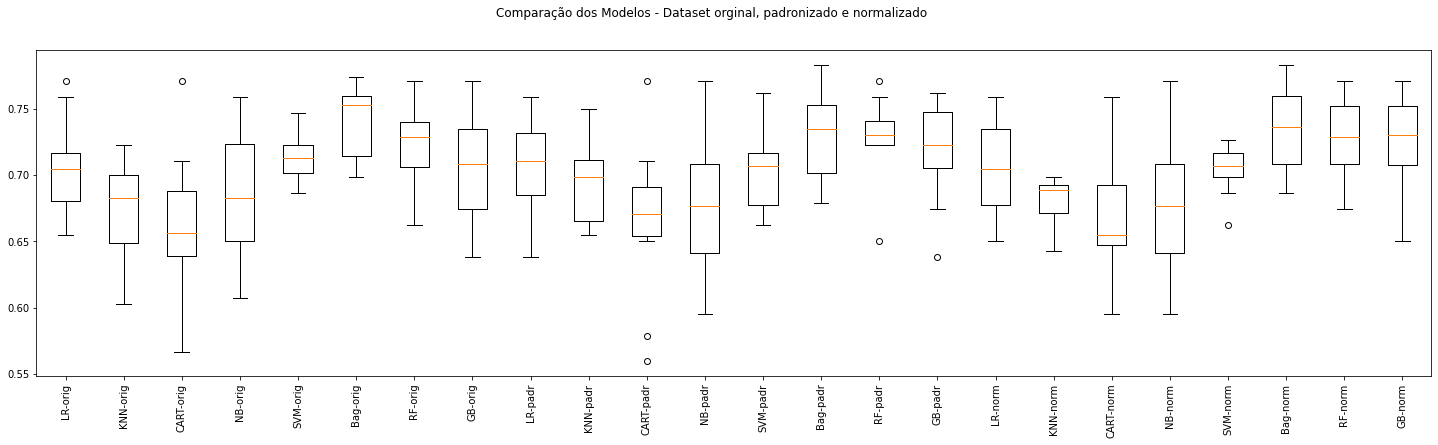

In [92]:
np.random.seed(7) # definindo uma semente global para este bloco
seed = 7 # semente aleatória
# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Definindo os parâmetros do classificador base para o BaggingClassifier
#base = DecisionTreeClassifier()
base = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
num_trees = 100
max_features = 3

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier(weights = 'distance', algorithm='kd_tree' ,n_neighbors = 12))
cart = ('CART', DecisionTreeClassifier(criterion = 'entropy', max_depth = 10))
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC(kernel = 'rbf', degree=4, C=1.1))
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
gradient_boosting = ('GB', GradientBoostingClassifier(max_depth=10, learning_rate=0.3, n_estimators=num_trees))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))

# Parâmetros e partições da validação cruzada
scoring = 'accuracy' # A métrica de avaliação do modelo vai ser acurácia
num_particoes = 12
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação, 

# Executando os pipelines
aux = 1
for name, model in pipelines:
    cv_results = cross_val_score(model, x_geral_limpo_reduzido.values, alvo.values, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)
    print('--------------------------------------------------------------')
    if aux == 8 or aux == 16 or aux ==24:  
        print('#############################################################')
    aux = aux + 1

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

<p>Apos variar os valores dos hiperparametros de cada modelo, o modelo que apresentou o melhor resultado em termos de acuracia foi um modelo <strong>ensemble (Bag)</strong>. O modelo bag com dados originais, sem padronização e sem normalização, obteve a melhor média de acertos, e o <strong>modelo bag normalizado</strong> obteve acertos mais uniformes, como visto no gráfico de boxplot.</p>

### Visão computacional

In [68]:
# importação dos modulos

import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical

from pathlib import Path

<a href="https://www.kaggle.com/datasets/fournierp/captcha-version-2-images">Fonte do dataset</a>  

<p>Este conjunto de dados contém imagens CAPTCHA (Teste de Turing Público Completamente Automatizado para Diferenciar Computadores e Humanos). Construído em 1997 como forma de os usuários identificarem e bloquearem bots (a fim de prevenir spam, DDOS etc.). Desde então, eles foram substituídos por reCAPTCHA porque são quebráveis usando Inteligência Artificial (como eu encorajo você a fazer).</p>

<p> As imagens são palavras de 5 letras que podem conter números. As imagens tiveram ruído aplicado a elas (desfoque e uma linha). São PNGs de 200 x 50.</p>

In [67]:
# funções de utilidades

def map_chave_valor(chav, val):
    mapeamento = {}
    for chave, valor in zip(chav, val):
        mapeamento[chave] = valor
    return mapeamento

def split_data(imagens, alvo, train_size=0.9, shuffle=True):
    tamanho = len(imagens)
    indices = np.arange(tamanho)
    if shuffle:
        np.random.shuffle(indices)
    amostra_treino = int(tamanho * train_size)
    print(indices[:amostra_treino].shape)
    x_treino, y_treino = imagens[indices[:amostra_treino]], alvo[indices[:amostra_treino]]
    x_teste, y_teste = imagens[indices[amostra_treino:]], alvo[indices[amostra_treino:]]
    return x_treino, x_teste, y_treino, y_teste

# Transforma os alvos de variáveis categóricas para valores discretos
def codifica_amostra(img_path,alvo):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img,channels=1)
    img = tf.image.convert_image_dtype(img,tf.float32)
    img = tf.image.resize(img,[50, 200])
    img = tf.transpose(img,perm=[1,0,2])
    alvo = caracter_para_numero(tf.strings.unicode_split(alvo, input_encoding="UTF-8"))
    return {"image":img,"label":alvo}

# Função utilitária para decodificar a saída da rede, de número para caracter
def decodificador(y_alvo):
    tamanho_ent = np.ones(y_alvo.shape[0]) * y_alvo.shape[1]
    resultado = keras.backend.ctc_decode(y_alvo, input_length=tamanho_ent, greedy=True)[0][0][:,:tamanho_max]
    
    # Interação sobre os resultados para recuperar o texto
    list_alvos_pred = []
    for res in resultado:
        res = tf.strings.reduce_join(numero_para_caracter(res)).numpy().decode("utf-8")
        list_alvos_pred.append(res)
    return list_alvos_pred

In [66]:
# "Connectionist Temporal Classification (CTC)" é um algoritmo usado para treinar redes neurais profundas em 
# reconhecimento de fala, reconhecimento de escrita e outros problemas.

class algoritimoCTC(layers.Layer):

    def __init__(self,name=None):
        super(algoritimoCTC, self).__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_real, y_predito):
        tamanho_Yreal = tf.cast(tf.shape(y_real)[0], dtype="int64")
        tamanho_Ypredito = tf.cast(tf.shape(y_predito)[1], dtype="int64")
        tamanho_saida = tf.cast(tf.shape(y_real)[1], dtype="int64")

        tamanho_Ypredito = tamanho_Ypredito * tf.ones(shape=(tamanho_Yreal, 1), dtype="int64")
        tamanho_saida = tamanho_saida * tf.ones(shape=(tamanho_Yreal, 1), dtype="int64")

        loss = self.loss_fn(y_real, y_predito, tamanho_Ypredito, tamanho_saida)
        self.add_loss(loss)
        
        return y_predito

In [57]:
def cria_modelo():
    # Entradas para o modelo.
    entrada_img = layers.Input(shape=(200, 50, 1), name="image", dtype="float32")
    alvos = layers.Input(name="label", shape=(None,), dtype="float32")

    # Primeiro bloco de conv.
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1",)(entrada_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Segundo bloco de conv.
    x = layers.Conv2D(64,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    # Aqui duas MaxPooling e Adiciona 64 filtros na camada.
    # passa a saída para a parte RNN do modelo a seguir.
    shape_alvo = ((200 // 4), (50 // 4) * 64)
    x = layers.Reshape(target_shape=shape_alvo, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="camada1")(x)
    x = layers.Dropout(0.2)(x)

    # Adiciona duas RNNs LSTM Bidirectionais de 128 e 64 neurônios respectivamente. 
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Camada de saída
    x = layers.Dense(21, activation="softmax", name="camada2")(x)

    # Adiciona a camada CTC para calcular a perda em cada etapa
    saida = algoritimoCTC(name='ctc_loss')(alvos, x)

    # Define o modelo
    modelo = keras.models.Model(inputs=[entrada_img, alvos], outputs=saida, name="modelo_sprint02")

    # Utiliza o otimizador Adam
    otm = keras.optimizers.Adam()
    
    # Compila o modelo e retornar
    modelo.compile(optimizer=otm)
    return modelo

modelo = cria_modelo()
modelo.summary()

Model: "modelo_sprint02"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
____________________________________________________________________________________

Imagens:  ['visao_computacional\\samples\\226md.png', 'visao_computacional\\samples\\22d5n.png', 'visao_computacional\\samples\\2356g.png', 'visao_computacional\\samples\\23mdg.png', 'visao_computacional\\samples\\23n88.png']
----------------------------------------------------------------------------------------------------------------
Alvos:  ['226md', '22d5n', '2356g', '23mdg', '23n88']
----------------------------------------------------------------------------------------------------------------
(50, 200, 4)


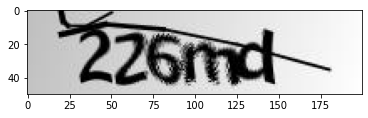

In [70]:
# O nosso alvo são os nomes das imagens, então vamos ler as imagens e colocar em uma lista ordenada
# extraír seus nomes e colocar na variável alvo.

data_dir = Path("visao_computacional/samples/")
dir_imagens = sorted(list(map(str,list(data_dir.glob("*.png")))))
alvo = [img.split(os.path.sep)[-1].split(".png")[0] for img in dir_imagens]

print('Imagens: ',dir_imagens[0:5])
print('----------------------------------------------------------------------------------------------------------------')
print('Alvos: ',alvo[0:5])
print('----------------------------------------------------------------------------------------------------------------')

# printando a 1ª imagen
img1 = Image.open(dir_imagens[0])
arr = np.array(img1)
print(arr.shape)
plt.imshow(img1)
plt.show()

In [60]:
# Aqui os caracters repetidos são retirados e é feita uma associação de caracteres para valores inteiros e de
# Valores inteiros para caracteres

caracteres = set(char for alvos in alvo for char in alvos)
caracteres = sorted(list(caracteres))
caracter_para_numero = layers.StringLookup(vocabulary=list(caracteres),mask_token=None)
numero_para_caracter = layers.StringLookup(vocabulary=caracter_para_numero.get_vocabulary(),mask_token=None,invert=True)

#### SEPARAÇÃO DOS DADOS EM TREINO E TESTE

In [71]:
x_treino, x_teste, y_treino, y_teste = split_data(np.array(dir_imagens), np.array(alvo))

print('x_treino: ', x_treino.shape)
print('y_treino: ', y_treino.shape)
print('x_teste: ', x_teste.shape)
print('y_teste: ',y_teste.shape)

batch_size = 12
tamanho_max = max([len(y) for y in alvo])

# separa os dados em dois datasets, um de treino e outro de teste com dados codificados. 
# os alvos serão transformados de variáveis categóricas nominais para discreta e as imagens em conjunto de valores continuos.

dataset_treino = tf.data.Dataset.from_tensor_slices((x_treino, y_treino))
dataset_treino = (dataset_treino.map(codifica_amostra, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

dataset_teste = tf.data.Dataset.from_tensor_slices((x_teste, y_teste))
dataset_teste = (dataset_teste.map(codifica_amostra, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

(936,)
x_treino:  (936,)
y_treino:  (936,)
x_teste:  (104,)
y_teste:  (104,)


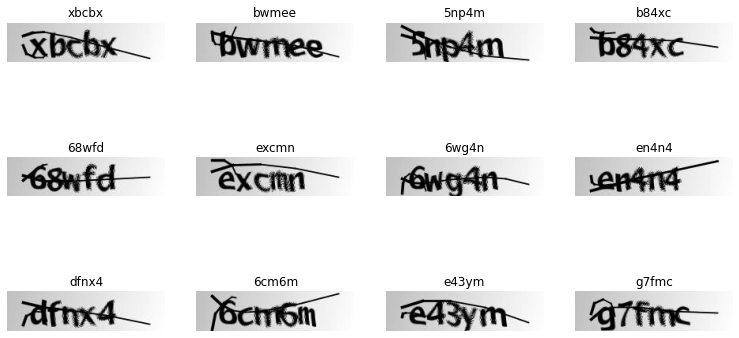

In [54]:
# Visualizando as imagens do primeiro batch_size
_, ax = plt.subplots(3, 4, figsize=(13, 7))
for k in dataset_treino.take(1):  # batch_size = 12, 12 imagens por vez
    imagens = k["image"]
    alvos = k["label"]
    for i in range(12):
        alvo =  tf.strings.reduce_join(numero_para_caracter(alvos[i])).numpy().decode("utf-8")
        img = (imagens[i] * 255).numpy().astype("uint8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(alvo)
        ax[i // 4, i % 4].axis("off")

In [53]:
# # Adcionando uma parada a cada 10 epocas para atualizar os pesos com os melhores pesos utilizados.
epocas = 100
parada_precoce = 10
parada_precoce_modelo = keras.callbacks.EarlyStopping(
                                                    monitor="loss",
                                                    patience=parada_precoce,
                                                    restore_best_weights=True)

# Treinamento do modelo
log = modelo.fit(dataset_treino, validation_data=dataset_teste, epochs=epocas, callbacks=[parada_precoce_modelo],)

Epoch 1/100
78/78 [==============================] - 28s 243ms/step - loss: 19.5114 - val_loss: 16.3206
Epoch 2/100
78/78 [==============================] - 18s 230ms/step - loss: 16.3605 - val_loss: 16.3100
Epoch 3/100
78/78 [==============================] - 17s 218ms/step - loss: 16.3501 - val_loss: 16.3018
Epoch 4/100
78/78 [==============================] - 17s 215ms/step - loss: 16.3459 - val_loss: 16.3054
Epoch 5/100
78/78 [==============================] - 17s 214ms/step - loss: 16.3352 - val_loss: 16.2830
Epoch 6/100
78/78 [==============================] - 17s 214ms/step - loss: 16.3105 - val_loss: 16.2645
Epoch 7/100
78/78 [==============================] - 17s 216ms/step - loss: 16.2424 - val_loss: 16.0275
Epoch 8/100
78/78 [==============================] - 18s 236ms/step - loss: 15.9520 - val_loss: 15.6311
Epoch 9/100
13/78 [====>.........................] - ETA: 14s - loss: 15.6825

KeyboardInterrupt: 

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            4921

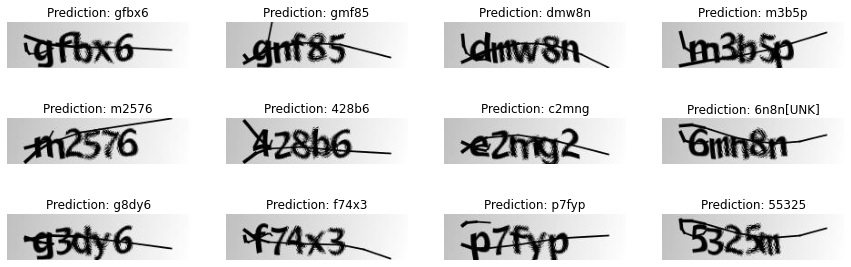

In [74]:
## Testando o modelo com dados não vistos. Dados de teste/validação

# Pega o modelo partindo de uma camada até a camada de saída
modelo_treinado = keras.models.Model(modelo.get_layer(name="image").input, modelo.get_layer(name="camada2").output)
modelo_treinado.summary()

# Verificando o resultado do teste para o primeiro lote(batch_size) de teste.
for k in dataset_teste.take(1):
    img_teste = k["image"]
    alvo_teste = k["label"]

    predicoes = modelo_treinado.predict(img_teste)
    pred_texts = decodificador(predicoes)
    orig_texts = []
    
    for label in alvo_teste:
        label = tf.strings.reduce_join(numero_para_caracter(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(3, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (img_teste[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Predição: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()